# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

In [1]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import tests

In [3]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
## Scale function will come later
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transform = [
                  transforms.Resize(size),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
    
    return transforms.Compose(transform)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [5]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.img_dir = directory
        self.transforms = transforms
        self.extension = extension
        self.list_of_images = glob(self.img_dir + "*" + self.extension)

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        print(len(self.list_of_images))
        return len(self.list_of_images)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        img_path = self.list_of_images[index]
        image = Image.open(img_path)
        if self.transforms:
            image = self.transforms(image)
        
        return image

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

32600
32600
Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

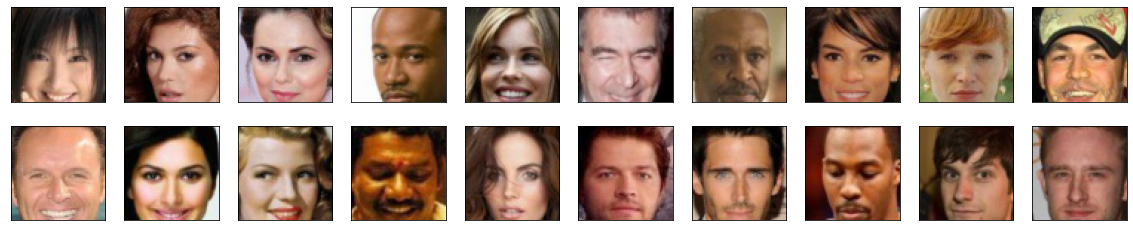

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [8]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import BatchNorm2d
from torch.nn import LeakyReLU
from torch.nn import Linear
from torch.nn import Flatten
from torch.nn import ConvTranspose2d
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Dropout
from torch.nn import Sequential
import torch.nn.functional as F
import torchsummary

In [9]:
class ConvBlock(Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool, stride: int, padding: int):
        super(ConvBlock, self).__init__()
        
        self.conv = Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = BatchNorm2d(out_channels)
        self.activation = LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [10]:
conv_dim = 64
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        # complete init function
        self.conv_dim = conv_dim

        # 64x64 input
        self.conv1 = ConvBlock(3, conv_dim, 4, batch_norm=False, stride=2, padding=1) # first layer, no batch_norm
        # 32x32 out
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4, batch_norm=True, stride=2, padding=1)
        # 16x16 out
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4, batch_norm=True, stride=2, padding=1)
        # 8x8 out
        self.conv4 = ConvBlock(conv_dim*4, conv_dim*8, 4, batch_norm=True, stride=2, padding=1)
        # 4x4 out
       
        self.flatten = Flatten()
        self.fc = Linear(conv_dim*8*4*4, 1)
        # final, fully-connected layer
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.conv1(x)
        #print( '1: '+ str(x.shape) )
        x = self.conv2(x)
        #print( '2: '+ str(x.shape) )
        x = self.conv3(x)
        #print( '3: '+ str(x.shape) )
        x = self.conv4(x)
        #print( '4: '+ str(x.shape) )
       
        # flatten
        x = self.flatten(x)
        # final output layer
        x = self.fc(x)
        # change dimension to [1,1,1,1]
        x = x[:,None,None, :]
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torchsummary.summary(Discriminator().to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
         ConvBlock-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
         ConvBlock-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 256, 8, 8]         524,288
       BatchNorm2d-9            [-1, 256, 8, 8]             512
        LeakyReLU-10            [-1, 256, 8, 8]               0
        ConvBlock-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        LeakyReLU-14            [-1, 51

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [13]:
from torch.nn import ConvTranspose2d
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Dropout
from torch.nn import Sequential
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss

In [14]:
def deconv_block(in_channels, out_channels,kernel_size=4, stride=2, padding=1, b_n=True):
    
    layers = []
         
    trans_block = ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False) # no bias bc of b_n mean=0
    layers.append(trans_block)
    if b_n:
        layers.append(BatchNorm2d(out_channels))    
    
    return Sequential(*layers)

In [15]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers
        self.conv_dim = 64
        
        self.deconv1 = deconv_block(latent_dim, conv_dim*8, 4, 1, 0)
        #256x4x4 
        self.deconv2 = deconv_block(conv_dim*8, conv_dim*4)
        #128x8x8
        self.deconv3 = deconv_block(conv_dim*4, conv_dim*2)
        #64x16x16
        self.deconv4 = deconv_block(conv_dim*2, conv_dim)
        #32x32x32
        self.deconv5 = deconv_block(conv_dim,3, b_n=False) # no batchnorm at generator output
        #3x64x64
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Implement the forward method
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        
        x = torch.tanh(self.deconv5(x))
        
        return x

In [16]:
print(Generator(128))

Generator(
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv5): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


In [17]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)

latent_vector = torch.randn(1, latent_dim, 1, 1)
image = generator(latent_vector)

print(image.shape)
tests.check_generator(generator, latent_dim)

torch.Size([1, 3, 64, 64])
Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [18]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

In [19]:
def real_loss(D_out, smooth=True):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [20]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
    return real_loss(fake_logits, False)

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [21]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 
    return real_loss(real_logits, False) + fake_loss(fake_logits)

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [22]:
def gradient_penalty(real_sample: torch.Tensor, 
                     fake_sample: torch.Tensor,
                     critic: Module) -> torch.Tensor:
    """
    Gradient penalty of the WGAN-GP model
    args:
    - real_sample: sample from the real dataset
    - fake_sample: generated sample
    
    returns:
    - gradient penalty
    """
    # sample a random point between both distributions
    alpha = torch.rand(real_sample.shape)
    x_hat = alpha * real_sample + (1 - alpha) * fake_sample
    
    # calculate the gradient
    x_hat.requires_grad = True
    pred = critic(x_hat)
    grad = torch.autograd.grad(pred, 
                               x_hat, 
                               grad_outputs=torch.ones_like(pred), 
                               create_graph=True)[0]
    
    # calculate the norm and the final penalty
    norm = torch.norm(grad.view(-1), 2)
    gp = ((norm - 1)**2).mean()    
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [23]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    generator.train()
    discriminator.train()
    
#     print("    Generator_step: Set the gradients to be zeros!")
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, latent_dim, 1, 1)
    #z = torch.from_numpy(z).float()
    if train_on_gpu:
        z = z.cuda()
        
#     print("    Generator_step: entering the generator!")
    fake_images = generator(z)
#     print("    Generator_step: generator successful!")
    # Compute the discriminator losses on fake images 
    # using flipped labels!
#     print("    Generator_step: fake image entering the discriminator!")
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake) # use real loss to flip labels    
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}

def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    generator.train()
    discriminator.train()
    
    d_optimizer.zero_grad()
    if train_on_gpu:
        real_images = real_images.cuda()
    D_real = discriminator(real_images)
    
    z = torch.randn(batch_size, latent_dim, 1, 1)
    #z = torch.from_numpy(z).float()
    
    # move x to GPU, if available
    if train_on_gpu:
        z = z.cuda()
        
    fake_images = generator(z)
    D_fake = discriminator(fake_images.detach())    
        
    d_loss = discriminator_loss(D_real, D_fake)
    d_loss.backward()
    d_optimizer.step()
    gp=0
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [24]:
from datetime import datetime

In [31]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 30

# number of images in each batch
batch_size = 64

conv_dim = 64

In [32]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 100

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

32600
32600


In [33]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [34]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    generator.cuda()
    discriminator.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


32600
32600
32600
2024-01-02 19:56:57 | Epoch [1/30] | Batch 0/509 | d_loss: 4.3338 | g_loss: 0.3459
32600
2024-01-02 19:57:18 | Epoch [1/30] | Batch 100/509 | d_loss: 1.6114 | g_loss: 0.8311
32600
2024-01-02 19:57:40 | Epoch [1/30] | Batch 200/509 | d_loss: 1.7085 | g_loss: 0.7733
32600
2024-01-02 19:58:01 | Epoch [1/30] | Batch 300/509 | d_loss: 1.3872 | g_loss: 0.7750
32600
2024-01-02 19:58:23 | Epoch [1/30] | Batch 400/509 | d_loss: 1.4479 | g_loss: 0.7369
32600
2024-01-02 19:58:45 | Epoch [1/30] | Batch 500/509 | d_loss: 1.4359 | g_loss: 0.7687
32600


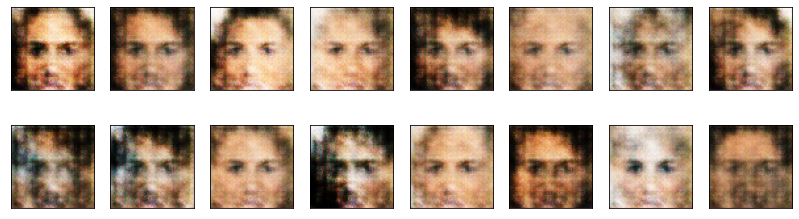

32600
32600
32600
2024-01-02 19:58:50 | Epoch [2/30] | Batch 0/509 | d_loss: 1.5198 | g_loss: 0.7904
32600
2024-01-02 19:59:11 | Epoch [2/30] | Batch 100/509 | d_loss: 1.3859 | g_loss: 0.8673
32600
2024-01-02 19:59:33 | Epoch [2/30] | Batch 200/509 | d_loss: 1.3418 | g_loss: 0.7995
32600
2024-01-02 19:59:54 | Epoch [2/30] | Batch 300/509 | d_loss: 1.4585 | g_loss: 0.7683
32600
2024-01-02 20:00:16 | Epoch [2/30] | Batch 400/509 | d_loss: 1.3935 | g_loss: 0.7456
32600
2024-01-02 20:00:37 | Epoch [2/30] | Batch 500/509 | d_loss: 1.4364 | g_loss: 0.6854
32600


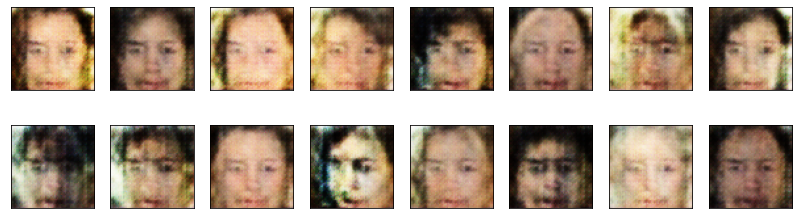

32600
32600
32600
2024-01-02 20:00:42 | Epoch [3/30] | Batch 0/509 | d_loss: 1.4444 | g_loss: 0.7121
32600
2024-01-02 20:01:04 | Epoch [3/30] | Batch 100/509 | d_loss: 1.5073 | g_loss: 0.7229
32600
2024-01-02 20:01:25 | Epoch [3/30] | Batch 200/509 | d_loss: 1.4288 | g_loss: 0.6752
32600
2024-01-02 20:01:47 | Epoch [3/30] | Batch 300/509 | d_loss: 1.4205 | g_loss: 0.7230
32600
2024-01-02 20:02:08 | Epoch [3/30] | Batch 400/509 | d_loss: 1.3841 | g_loss: 0.8337
32600
2024-01-02 20:02:30 | Epoch [3/30] | Batch 500/509 | d_loss: 1.4130 | g_loss: 0.7448
32600


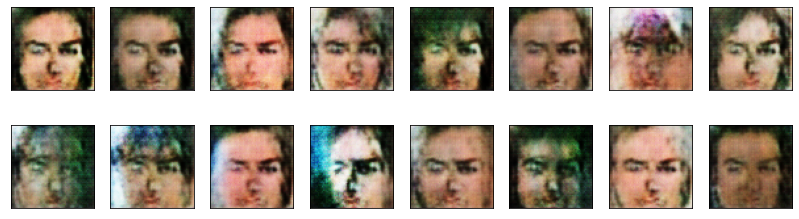

32600
32600
32600
2024-01-02 20:02:36 | Epoch [4/30] | Batch 0/509 | d_loss: 1.4036 | g_loss: 0.8472
32600
2024-01-02 20:02:57 | Epoch [4/30] | Batch 100/509 | d_loss: 1.3923 | g_loss: 0.7134
32600
2024-01-02 20:03:19 | Epoch [4/30] | Batch 200/509 | d_loss: 1.4153 | g_loss: 0.7924
32600
2024-01-02 20:03:40 | Epoch [4/30] | Batch 300/509 | d_loss: 1.3906 | g_loss: 0.7613
32600
2024-01-02 20:04:02 | Epoch [4/30] | Batch 400/509 | d_loss: 1.4293 | g_loss: 0.6879
32600
2024-01-02 20:04:23 | Epoch [4/30] | Batch 500/509 | d_loss: 1.4225 | g_loss: 0.7259
32600


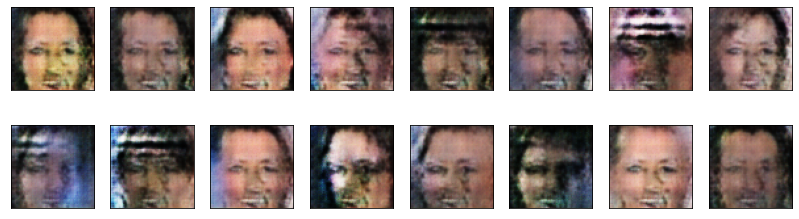

32600
32600
32600
2024-01-02 20:04:28 | Epoch [5/30] | Batch 0/509 | d_loss: 1.4215 | g_loss: 0.7178
32600
2024-01-02 20:04:50 | Epoch [5/30] | Batch 100/509 | d_loss: 1.4073 | g_loss: 0.8072
32600
2024-01-02 20:05:11 | Epoch [5/30] | Batch 200/509 | d_loss: 1.4208 | g_loss: 0.7515
32600
2024-01-02 20:05:33 | Epoch [5/30] | Batch 300/509 | d_loss: 1.4170 | g_loss: 0.6956
32600
2024-01-02 20:05:54 | Epoch [5/30] | Batch 400/509 | d_loss: 1.4315 | g_loss: 0.7609
32600
2024-01-02 20:06:16 | Epoch [5/30] | Batch 500/509 | d_loss: 1.4121 | g_loss: 0.7210
32600


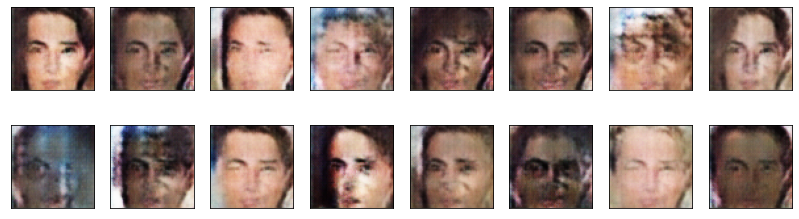

32600
32600
32600
2024-01-02 20:06:21 | Epoch [6/30] | Batch 0/509 | d_loss: 1.4160 | g_loss: 0.7620
32600
2024-01-02 20:06:43 | Epoch [6/30] | Batch 100/509 | d_loss: 1.4051 | g_loss: 0.7537
32600
2024-01-02 20:07:04 | Epoch [6/30] | Batch 200/509 | d_loss: 1.4242 | g_loss: 0.7576
32600
2024-01-02 20:07:26 | Epoch [6/30] | Batch 300/509 | d_loss: 1.4006 | g_loss: 0.7640
32600
2024-01-02 20:07:48 | Epoch [6/30] | Batch 400/509 | d_loss: 1.4347 | g_loss: 0.7172
32600
2024-01-02 20:08:09 | Epoch [6/30] | Batch 500/509 | d_loss: 1.4307 | g_loss: 0.7715
32600


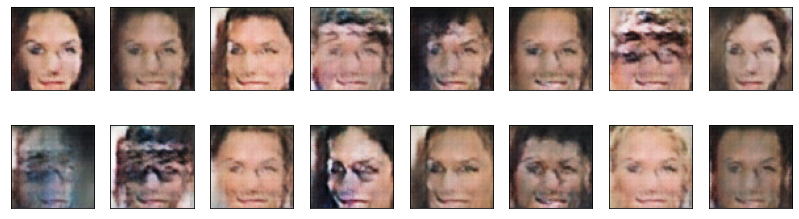

32600
32600
32600
2024-01-02 20:08:15 | Epoch [7/30] | Batch 0/509 | d_loss: 1.4027 | g_loss: 0.7609
32600
2024-01-02 20:08:36 | Epoch [7/30] | Batch 100/509 | d_loss: 1.4171 | g_loss: 0.7532
32600
2024-01-02 20:08:58 | Epoch [7/30] | Batch 200/509 | d_loss: 1.3975 | g_loss: 0.7329
32600
2024-01-02 20:09:19 | Epoch [7/30] | Batch 300/509 | d_loss: 1.4167 | g_loss: 0.6165
32600
2024-01-02 20:09:41 | Epoch [7/30] | Batch 400/509 | d_loss: 1.4100 | g_loss: 0.8247
32600
2024-01-02 20:10:02 | Epoch [7/30] | Batch 500/509 | d_loss: 1.4633 | g_loss: 1.0435
32600


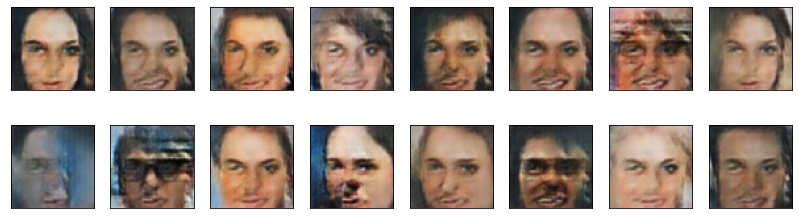

32600
32600
32600
2024-01-02 20:10:09 | Epoch [8/30] | Batch 0/509 | d_loss: 1.3718 | g_loss: 0.7975
32600
2024-01-02 20:10:31 | Epoch [8/30] | Batch 100/509 | d_loss: 1.4453 | g_loss: 0.6490
32600
2024-01-02 20:10:52 | Epoch [8/30] | Batch 200/509 | d_loss: 1.3863 | g_loss: 0.8718
32600
2024-01-02 20:11:14 | Epoch [8/30] | Batch 300/509 | d_loss: 1.4346 | g_loss: 0.7335
32600
2024-01-02 20:11:35 | Epoch [8/30] | Batch 400/509 | d_loss: 1.3457 | g_loss: 0.7983
32600
2024-01-02 20:11:56 | Epoch [8/30] | Batch 500/509 | d_loss: 1.3505 | g_loss: 0.7614
32600


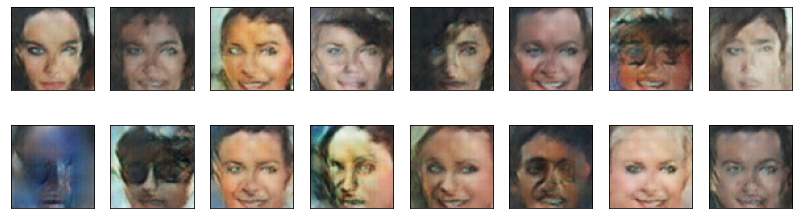

32600
32600
32600
2024-01-02 20:12:03 | Epoch [9/30] | Batch 0/509 | d_loss: 1.4075 | g_loss: 0.6632
32600
2024-01-02 20:12:24 | Epoch [9/30] | Batch 100/509 | d_loss: 1.3967 | g_loss: 0.9738
32600
2024-01-02 20:12:46 | Epoch [9/30] | Batch 200/509 | d_loss: 1.3304 | g_loss: 0.8549
32600
2024-01-02 20:13:07 | Epoch [9/30] | Batch 300/509 | d_loss: 1.2004 | g_loss: 0.9257
32600
2024-01-02 20:13:29 | Epoch [9/30] | Batch 400/509 | d_loss: 1.3665 | g_loss: 0.9170
32600
2024-01-02 20:13:50 | Epoch [9/30] | Batch 500/509 | d_loss: 1.6547 | g_loss: 0.4584
32600


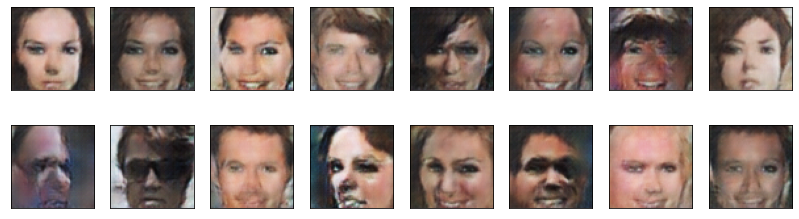

32600
32600
32600
2024-01-02 20:13:56 | Epoch [10/30] | Batch 0/509 | d_loss: 1.2123 | g_loss: 1.1961
32600
2024-01-02 20:14:18 | Epoch [10/30] | Batch 100/509 | d_loss: 1.2338 | g_loss: 1.1341
32600
2024-01-02 20:14:39 | Epoch [10/30] | Batch 200/509 | d_loss: 1.2775 | g_loss: 0.8643
32600
2024-01-02 20:15:01 | Epoch [10/30] | Batch 300/509 | d_loss: 1.2513 | g_loss: 0.9340
32600
2024-01-02 20:15:22 | Epoch [10/30] | Batch 400/509 | d_loss: 1.2431 | g_loss: 1.2882
32600
2024-01-02 20:15:43 | Epoch [10/30] | Batch 500/509 | d_loss: 1.1878 | g_loss: 1.6789
32600


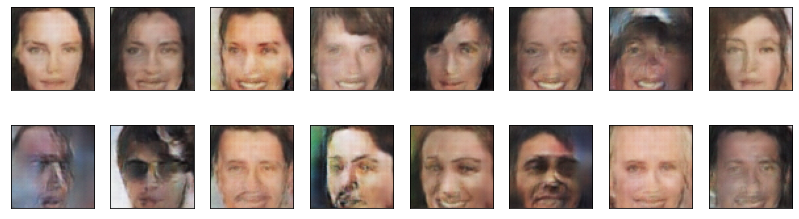

32600
32600
32600
2024-01-02 20:15:50 | Epoch [11/30] | Batch 0/509 | d_loss: 1.2495 | g_loss: 0.8408
32600
2024-01-02 20:16:11 | Epoch [11/30] | Batch 100/509 | d_loss: 1.0729 | g_loss: 1.0654
32600
2024-01-02 20:16:33 | Epoch [11/30] | Batch 200/509 | d_loss: 1.1077 | g_loss: 1.2350
32600
2024-01-02 20:16:55 | Epoch [11/30] | Batch 300/509 | d_loss: 1.3113 | g_loss: 0.9330
32600
2024-01-02 20:17:16 | Epoch [11/30] | Batch 400/509 | d_loss: 1.0729 | g_loss: 1.9509
32600
2024-01-02 20:17:38 | Epoch [11/30] | Batch 500/509 | d_loss: 1.1658 | g_loss: 1.6301
32600


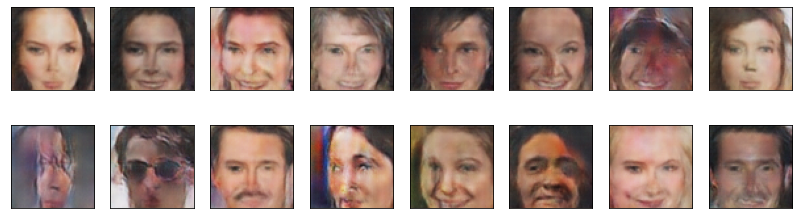

32600
32600
32600
2024-01-02 20:17:45 | Epoch [12/30] | Batch 0/509 | d_loss: 1.0412 | g_loss: 0.9881
32600
2024-01-02 20:18:06 | Epoch [12/30] | Batch 100/509 | d_loss: 1.0845 | g_loss: 1.2276
32600
2024-01-02 20:18:28 | Epoch [12/30] | Batch 200/509 | d_loss: 0.9802 | g_loss: 1.6645
32600
2024-01-02 20:18:49 | Epoch [12/30] | Batch 300/509 | d_loss: 1.1371 | g_loss: 1.2601
32600
2024-01-02 20:19:11 | Epoch [12/30] | Batch 400/509 | d_loss: 1.3295 | g_loss: 0.8468
32600
2024-01-02 20:19:32 | Epoch [12/30] | Batch 500/509 | d_loss: 0.7281 | g_loss: 1.8582
32600


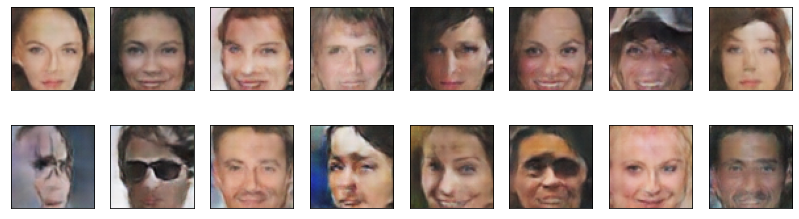

32600
32600
32600
2024-01-02 20:19:38 | Epoch [13/30] | Batch 0/509 | d_loss: 1.9813 | g_loss: 3.5699
32600
2024-01-02 20:19:59 | Epoch [13/30] | Batch 100/509 | d_loss: 0.9812 | g_loss: 1.2591
32600
2024-01-02 20:20:21 | Epoch [13/30] | Batch 200/509 | d_loss: 1.3902 | g_loss: 0.6445
32600
2024-01-02 20:20:42 | Epoch [13/30] | Batch 300/509 | d_loss: 0.7827 | g_loss: 2.1816
32600
2024-01-02 20:21:03 | Epoch [13/30] | Batch 400/509 | d_loss: 1.0818 | g_loss: 1.0497
32600
2024-01-02 20:21:25 | Epoch [13/30] | Batch 500/509 | d_loss: 1.0203 | g_loss: 0.9150
32600


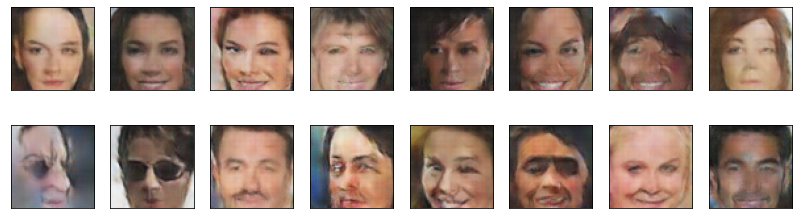

32600
32600
32600
2024-01-02 20:21:31 | Epoch [14/30] | Batch 0/509 | d_loss: 0.7609 | g_loss: 1.8399
32600
2024-01-02 20:21:52 | Epoch [14/30] | Batch 100/509 | d_loss: 0.7823 | g_loss: 2.9244
32600
2024-01-02 20:22:14 | Epoch [14/30] | Batch 200/509 | d_loss: 0.8211 | g_loss: 2.2169
32600
2024-01-02 20:22:35 | Epoch [14/30] | Batch 300/509 | d_loss: 0.7644 | g_loss: 1.6449
32600
2024-01-02 20:22:57 | Epoch [14/30] | Batch 400/509 | d_loss: 0.6483 | g_loss: 1.2943
32600
2024-01-02 20:23:18 | Epoch [14/30] | Batch 500/509 | d_loss: 0.5683 | g_loss: 1.8091
32600


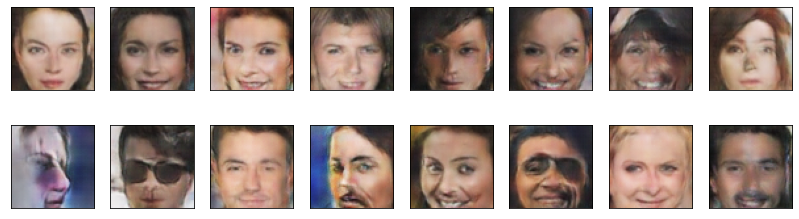

32600
32600
32600
2024-01-02 20:23:23 | Epoch [15/30] | Batch 0/509 | d_loss: 0.6582 | g_loss: 2.5451
32600
2024-01-02 20:23:45 | Epoch [15/30] | Batch 100/509 | d_loss: 0.6998 | g_loss: 2.3008
32600
2024-01-02 20:24:06 | Epoch [15/30] | Batch 200/509 | d_loss: 0.6235 | g_loss: 3.7312
32600
2024-01-02 20:24:28 | Epoch [15/30] | Batch 300/509 | d_loss: 1.0892 | g_loss: 4.1064
32600
2024-01-02 20:24:49 | Epoch [15/30] | Batch 400/509 | d_loss: 0.6931 | g_loss: 1.0927
32600
2024-01-02 20:25:10 | Epoch [15/30] | Batch 500/509 | d_loss: 0.6167 | g_loss: 1.4418
32600


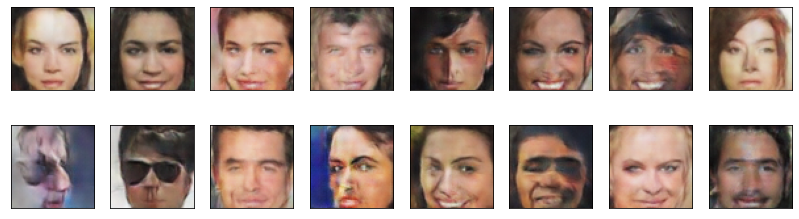

32600
32600
32600
2024-01-02 20:25:17 | Epoch [16/30] | Batch 0/509 | d_loss: 0.5482 | g_loss: 2.2132
32600
2024-01-02 20:25:38 | Epoch [16/30] | Batch 100/509 | d_loss: 0.4798 | g_loss: 2.1539
32600
2024-01-02 20:26:00 | Epoch [16/30] | Batch 200/509 | d_loss: 0.5151 | g_loss: 2.0588
32600
2024-01-02 20:26:21 | Epoch [16/30] | Batch 300/509 | d_loss: 0.7726 | g_loss: 1.2769
32600
2024-01-02 20:26:42 | Epoch [16/30] | Batch 400/509 | d_loss: 0.2095 | g_loss: 3.1783
32600
2024-01-02 20:27:04 | Epoch [16/30] | Batch 500/509 | d_loss: 0.2682 | g_loss: 2.6214
32600


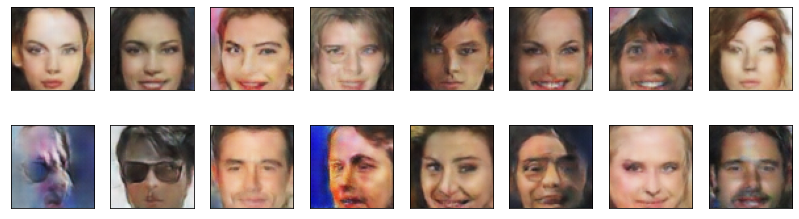

32600
32600
32600
2024-01-02 20:27:10 | Epoch [17/30] | Batch 0/509 | d_loss: 0.3636 | g_loss: 2.1930
32600
2024-01-02 20:27:32 | Epoch [17/30] | Batch 100/509 | d_loss: 1.1241 | g_loss: 0.9190
32600
2024-01-02 20:27:53 | Epoch [17/30] | Batch 200/509 | d_loss: 0.6887 | g_loss: 3.7911
32600
2024-01-02 20:28:14 | Epoch [17/30] | Batch 300/509 | d_loss: 1.3235 | g_loss: 1.2700
32600
2024-01-02 20:28:36 | Epoch [17/30] | Batch 400/509 | d_loss: 0.3955 | g_loss: 3.0892
32600
2024-01-02 20:28:57 | Epoch [17/30] | Batch 500/509 | d_loss: 0.9064 | g_loss: 3.5578
32600


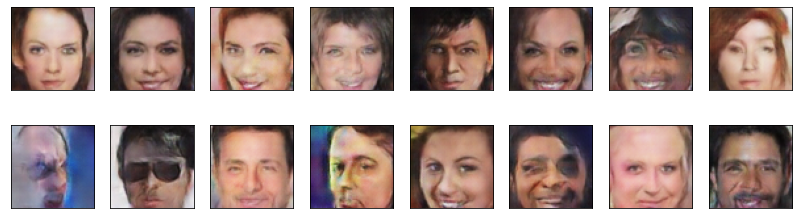

32600
32600
32600
2024-01-02 20:29:03 | Epoch [18/30] | Batch 0/509 | d_loss: 0.5876 | g_loss: 2.4088
32600
2024-01-02 20:29:24 | Epoch [18/30] | Batch 100/509 | d_loss: 0.5652 | g_loss: 2.0066
32600
2024-01-02 20:29:46 | Epoch [18/30] | Batch 200/509 | d_loss: 1.0545 | g_loss: 0.9349
32600
2024-01-02 20:30:07 | Epoch [18/30] | Batch 300/509 | d_loss: 0.5246 | g_loss: 1.6546
32600
2024-01-02 20:30:28 | Epoch [18/30] | Batch 400/509 | d_loss: 0.2786 | g_loss: 3.1033
32600
2024-01-02 20:30:50 | Epoch [18/30] | Batch 500/509 | d_loss: 0.4031 | g_loss: 1.8936
32600


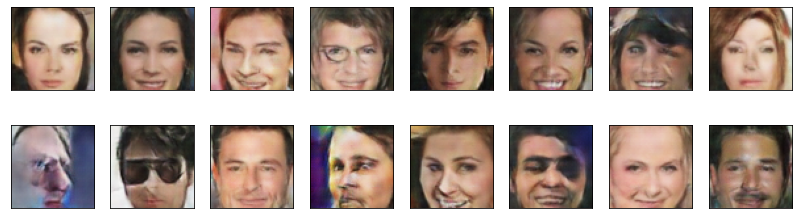

32600
32600
32600
2024-01-02 20:30:56 | Epoch [19/30] | Batch 0/509 | d_loss: 1.2243 | g_loss: 0.5763
32600
2024-01-02 20:31:17 | Epoch [19/30] | Batch 100/509 | d_loss: 0.4953 | g_loss: 3.3696
32600
2024-01-02 20:31:39 | Epoch [19/30] | Batch 200/509 | d_loss: 0.4234 | g_loss: 2.0735
32600
2024-01-02 20:32:00 | Epoch [19/30] | Batch 300/509 | d_loss: 0.4795 | g_loss: 3.8346
32600
2024-01-02 20:32:21 | Epoch [19/30] | Batch 400/509 | d_loss: 0.2231 | g_loss: 3.4251
32600
2024-01-02 20:32:42 | Epoch [19/30] | Batch 500/509 | d_loss: 0.3488 | g_loss: 3.1338
32600


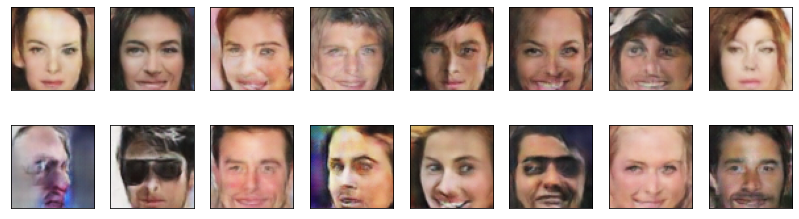

32600
32600
32600
2024-01-02 20:32:48 | Epoch [20/30] | Batch 0/509 | d_loss: 1.2356 | g_loss: 0.7566
32600
2024-01-02 20:33:09 | Epoch [20/30] | Batch 100/509 | d_loss: 0.5747 | g_loss: 5.0582
32600
2024-01-02 20:33:30 | Epoch [20/30] | Batch 200/509 | d_loss: 0.3345 | g_loss: 3.0655
32600
2024-01-02 20:33:51 | Epoch [20/30] | Batch 300/509 | d_loss: 0.6627 | g_loss: 1.7327
32600
2024-01-02 20:34:13 | Epoch [20/30] | Batch 400/509 | d_loss: 0.2741 | g_loss: 2.3493
32600
2024-01-02 20:34:34 | Epoch [20/30] | Batch 500/509 | d_loss: 0.6418 | g_loss: 5.1623
32600


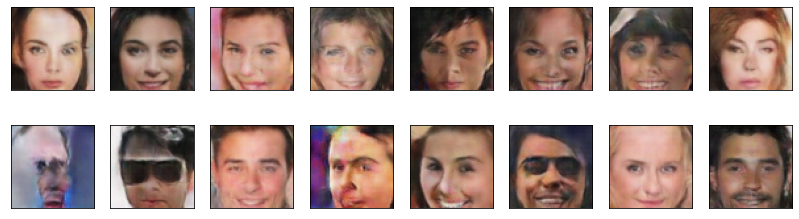

32600
32600
32600
2024-01-02 20:34:39 | Epoch [21/30] | Batch 0/509 | d_loss: 0.5782 | g_loss: 1.5144
32600
2024-01-02 20:35:01 | Epoch [21/30] | Batch 100/509 | d_loss: 0.4481 | g_loss: 2.6649
32600
2024-01-02 20:35:22 | Epoch [21/30] | Batch 200/509 | d_loss: 0.7800 | g_loss: 4.7073
32600
2024-01-02 20:35:43 | Epoch [21/30] | Batch 300/509 | d_loss: 0.3440 | g_loss: 3.0192
32600
2024-01-02 20:36:04 | Epoch [21/30] | Batch 400/509 | d_loss: 0.3798 | g_loss: 2.0128
32600
2024-01-02 20:36:25 | Epoch [21/30] | Batch 500/509 | d_loss: 0.2563 | g_loss: 3.2250
32600


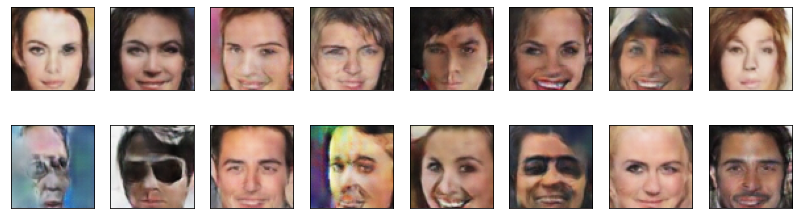

32600
32600
32600
2024-01-02 20:36:31 | Epoch [22/30] | Batch 0/509 | d_loss: 0.9298 | g_loss: 1.4588
32600
2024-01-02 20:36:52 | Epoch [22/30] | Batch 100/509 | d_loss: 0.4618 | g_loss: 2.3382
32600
2024-01-02 20:37:14 | Epoch [22/30] | Batch 200/509 | d_loss: 0.2243 | g_loss: 3.6702
32600
2024-01-02 20:37:35 | Epoch [22/30] | Batch 300/509 | d_loss: 0.1385 | g_loss: 3.1822
32600
2024-01-02 20:37:56 | Epoch [22/30] | Batch 400/509 | d_loss: 0.2667 | g_loss: 4.9379
32600
2024-01-02 20:38:17 | Epoch [22/30] | Batch 500/509 | d_loss: 0.3697 | g_loss: 3.0008
32600


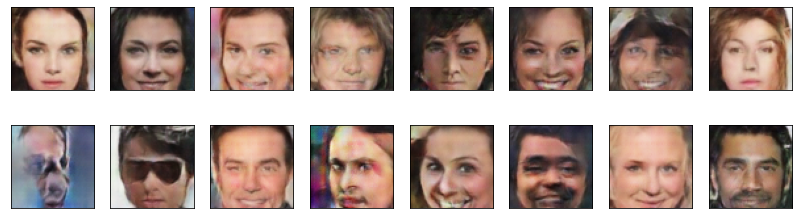

32600
32600
32600
2024-01-02 20:38:22 | Epoch [23/30] | Batch 0/509 | d_loss: 0.3058 | g_loss: 2.6787
32600
2024-01-02 20:38:43 | Epoch [23/30] | Batch 100/509 | d_loss: 0.2456 | g_loss: 2.4931
32600
2024-01-02 20:39:04 | Epoch [23/30] | Batch 200/509 | d_loss: 0.3378 | g_loss: 2.7823
32600
2024-01-02 20:39:26 | Epoch [23/30] | Batch 300/509 | d_loss: 1.6875 | g_loss: 0.4964
32600
2024-01-02 20:39:47 | Epoch [23/30] | Batch 400/509 | d_loss: 1.2164 | g_loss: 0.6755
32600
2024-01-02 20:40:09 | Epoch [23/30] | Batch 500/509 | d_loss: 0.2878 | g_loss: 3.1404
32600


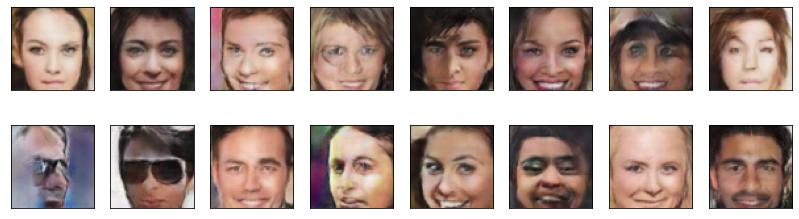

32600
32600
32600
2024-01-02 20:40:14 | Epoch [24/30] | Batch 0/509 | d_loss: 0.2361 | g_loss: 3.2519
32600
2024-01-02 20:40:35 | Epoch [24/30] | Batch 100/509 | d_loss: 0.5026 | g_loss: 3.1142
32600
2024-01-02 20:40:57 | Epoch [24/30] | Batch 200/509 | d_loss: 0.1457 | g_loss: 2.6666
32600
2024-01-02 20:41:18 | Epoch [24/30] | Batch 300/509 | d_loss: 0.2032 | g_loss: 2.7050
32600
2024-01-02 20:41:39 | Epoch [24/30] | Batch 400/509 | d_loss: 0.1453 | g_loss: 3.3749
32600
2024-01-02 20:42:00 | Epoch [24/30] | Batch 500/509 | d_loss: 1.2436 | g_loss: 0.8595
32600


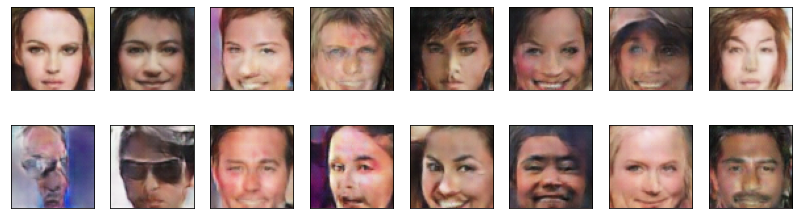

32600
32600
32600
2024-01-02 20:42:05 | Epoch [25/30] | Batch 0/509 | d_loss: 0.7403 | g_loss: 1.3609
32600
2024-01-02 20:42:26 | Epoch [25/30] | Batch 100/509 | d_loss: 0.2529 | g_loss: 4.4819
32600
2024-01-02 20:42:47 | Epoch [25/30] | Batch 200/509 | d_loss: 0.3536 | g_loss: 1.9151
32600
2024-01-02 20:43:08 | Epoch [25/30] | Batch 300/509 | d_loss: 0.3223 | g_loss: 2.2809
32600
2024-01-02 20:43:29 | Epoch [25/30] | Batch 400/509 | d_loss: 0.3071 | g_loss: 4.2511
32600
2024-01-02 20:43:50 | Epoch [25/30] | Batch 500/509 | d_loss: 0.2033 | g_loss: 3.0476
32600


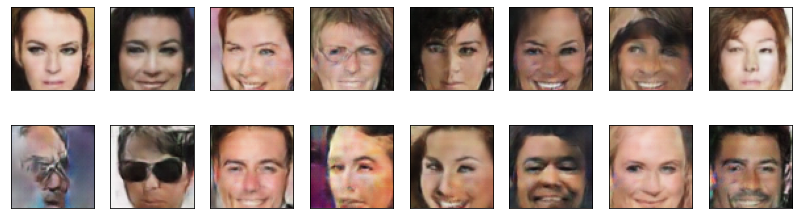

32600
32600
32600
2024-01-02 20:43:55 | Epoch [26/30] | Batch 0/509 | d_loss: 1.8798 | g_loss: 0.5205
32600
2024-01-02 20:44:16 | Epoch [26/30] | Batch 100/509 | d_loss: 0.3101 | g_loss: 3.4094
32600
2024-01-02 20:44:37 | Epoch [26/30] | Batch 200/509 | d_loss: 0.4913 | g_loss: 4.1154
32600
2024-01-02 20:44:58 | Epoch [26/30] | Batch 300/509 | d_loss: 0.5958 | g_loss: 4.4508
32600
2024-01-02 20:45:19 | Epoch [26/30] | Batch 400/509 | d_loss: 0.1561 | g_loss: 2.9023
32600
2024-01-02 20:45:40 | Epoch [26/30] | Batch 500/509 | d_loss: 0.2071 | g_loss: 2.7097
32600


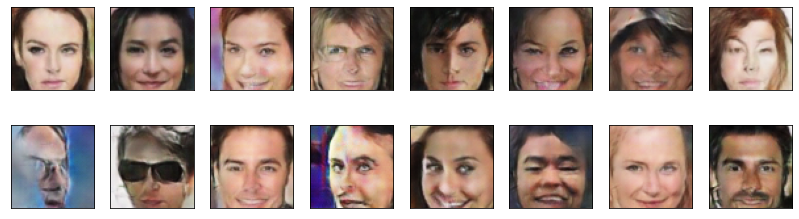

32600
32600
32600
2024-01-02 20:45:45 | Epoch [27/30] | Batch 0/509 | d_loss: 0.6207 | g_loss: 1.4532
32600
2024-01-02 20:46:07 | Epoch [27/30] | Batch 100/509 | d_loss: 0.3224 | g_loss: 2.6705
32600
2024-01-02 20:46:28 | Epoch [27/30] | Batch 200/509 | d_loss: 0.4415 | g_loss: 3.9615
32600
2024-01-02 20:46:49 | Epoch [27/30] | Batch 300/509 | d_loss: 0.2701 | g_loss: 2.4121
32600
2024-01-02 20:47:10 | Epoch [27/30] | Batch 400/509 | d_loss: 0.3767 | g_loss: 3.0809
32600
2024-01-02 20:47:31 | Epoch [27/30] | Batch 500/509 | d_loss: 0.1476 | g_loss: 3.7411
32600


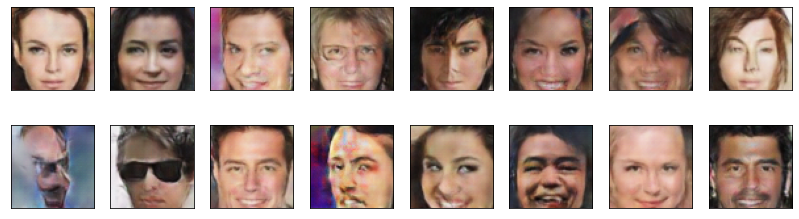

32600
32600
32600
2024-01-02 20:47:37 | Epoch [28/30] | Batch 0/509 | d_loss: 0.2655 | g_loss: 3.3734
32600
2024-01-02 20:47:58 | Epoch [28/30] | Batch 100/509 | d_loss: 1.1995 | g_loss: 7.1595
32600
2024-01-02 20:48:20 | Epoch [28/30] | Batch 200/509 | d_loss: 0.1456 | g_loss: 3.9287
32600
2024-01-02 20:48:41 | Epoch [28/30] | Batch 300/509 | d_loss: 0.4028 | g_loss: 4.5945
32600
2024-01-02 20:49:02 | Epoch [28/30] | Batch 400/509 | d_loss: 0.2274 | g_loss: 2.5739
32600
2024-01-02 20:49:23 | Epoch [28/30] | Batch 500/509 | d_loss: 0.3256 | g_loss: 3.9606
32600


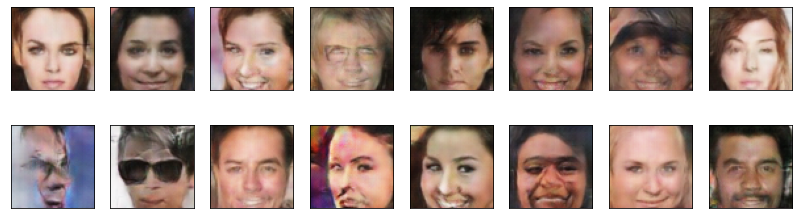

32600
32600
32600
2024-01-02 20:49:28 | Epoch [29/30] | Batch 0/509 | d_loss: 1.0416 | g_loss: 0.8349
32600
2024-01-02 20:49:49 | Epoch [29/30] | Batch 100/509 | d_loss: 0.9139 | g_loss: 3.7799
32600
2024-01-02 20:50:10 | Epoch [29/30] | Batch 200/509 | d_loss: 0.2599 | g_loss: 3.8288
32600
2024-01-02 20:50:31 | Epoch [29/30] | Batch 300/509 | d_loss: 2.8295 | g_loss: 9.1548
32600
2024-01-02 20:50:52 | Epoch [29/30] | Batch 400/509 | d_loss: 0.3942 | g_loss: 3.0441
32600
2024-01-02 20:51:13 | Epoch [29/30] | Batch 500/509 | d_loss: 0.1924 | g_loss: 3.5321
32600


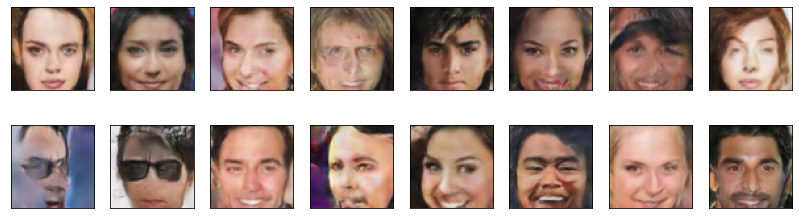

32600
32600
32600
2024-01-02 20:51:18 | Epoch [30/30] | Batch 0/509 | d_loss: 0.4672 | g_loss: 6.5401
32600
2024-01-02 20:51:39 | Epoch [30/30] | Batch 100/509 | d_loss: 0.1558 | g_loss: 2.6695
32600
2024-01-02 20:52:00 | Epoch [30/30] | Batch 200/509 | d_loss: 0.2387 | g_loss: 3.0676
32600
2024-01-02 20:52:21 | Epoch [30/30] | Batch 300/509 | d_loss: 0.2968 | g_loss: 5.0202
32600
2024-01-02 20:52:42 | Epoch [30/30] | Batch 400/509 | d_loss: 0.0828 | g_loss: 3.4985
32600
2024-01-02 20:53:03 | Epoch [30/30] | Batch 500/509 | d_loss: 0.2227 | g_loss: 4.2301
32600


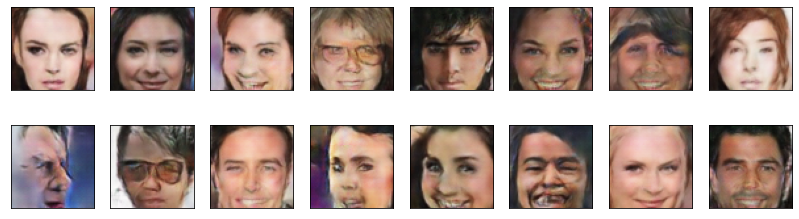

In [35]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

samples = []
losses = []

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, latent_dim, 1, 1))
fixed_z = torch.from_numpy(fixed_z).float()

for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        
        batch_size = real_images.size(0)
        # TODO: implement the training strategy
#         print("Enter the generator step!")
#         for i in range(5):
#             g_loss = generator_step(batch_size, latent_dim) 
        g_loss1 = generator_step(batch_size, latent_dim) 
        g_loss2 = generator_step(batch_size, latent_dim)
        g_loss3 = generator_step(batch_size, latent_dim)
        g_loss = {'loss': (g_loss1['loss'] + g_loss2['loss'] + g_loss3['loss'])/3}
        
#         print("Generator successful! Enter the discriminator!")
        d_loss=discriminator_step(batch_size, latent_dim, real_images)
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

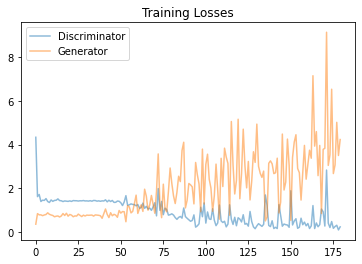

In [36]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** 
- Generator loss is usually higher than discriminator, so I trained generator more
- Maybe I can change the convolutional layers so that it could yield better results
- Changing the loss function might be helpful
- Change the model to StyleGan

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.